# Intermediate Machine Learning: Transfer Learning and Lime Visualizations

In this notebook we will: 

1. Briefly review preparing image data and creating a CNN to classify images
2. Demonstrate transfer learning from a pretrained CNN model
3. Explain a model prediction using an image.

# Part 1: Intro to CNNs

# The Dataset

We will be using the [Muffin or Chihuahua dataset](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification).  This is from Kaggle, and includes images of muffins and various dogs (Not just chihuahuas)

It was originally inspired by this meme: 

![Muffin or Chihuahua](https://i.postimg.cc/2SXNWP7f/muffin-meme2.jpg)



# The Business Problem

Our task is to create a computer vision model that can ingest an image in one of these and accurately classify it.  

# Imports

!pip install matplotlib
!pip install pandas

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import glob

import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models, callbacks
import visualkeras as vk

# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Custom Functions

In [3]:
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()
    return fig, axes

def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f",
                           class_labels=None):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred, target_names=class_labels)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0],
                                           display_labels=class_labels);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1],
                                            display_labels=class_labels);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=class_labels)
        return report_dict

def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False,
                                    class_labels=None):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data',
                                              class_labels=class_labels)
        
    

    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data',
                                             class_labels=class_labels)




## Data Exploration

Let's take a look at the files we have to use to train and validate our model.  We will start by creating lists of paths to each folder.

In [4]:
# examine folders 
folder = 'Data/muffin_chihuahua/'

train_folders = glob.glob(folder + 'train/*')
test_folders = glob.glob(folder + 'test/*')
display('training folders', train_folders)
print()
display('testing folders', test_folders)

'training folders'

['Data/muffin_chihuahua/train\\chihuahua',
 'Data/muffin_chihuahua/train\\muffin']

'testing folders'

['Data/muffin_chihuahua/test\\chihuahua', 'Data/muffin_chihuahua/test\\muffin']

Now let's grab the paths to the training images so we can explore them.

In [5]:
# get image file names

train_imgs = glob.glob(folder + '/train/*/*')
train_imgs[:5]

['Data/muffin_chihuahua//train\\chihuahua\\img_0_0.jpg',
 'Data/muffin_chihuahua//train\\chihuahua\\img_0_1.jpg',
 'Data/muffin_chihuahua//train\\chihuahua\\img_0_10.jpg',
 'Data/muffin_chihuahua//train\\chihuahua\\img_0_100.jpg',
 'Data/muffin_chihuahua//train\\chihuahua\\img_0_1003.jpg']

## Examine One Image

A good place to start in exploring image data is to look at a few.

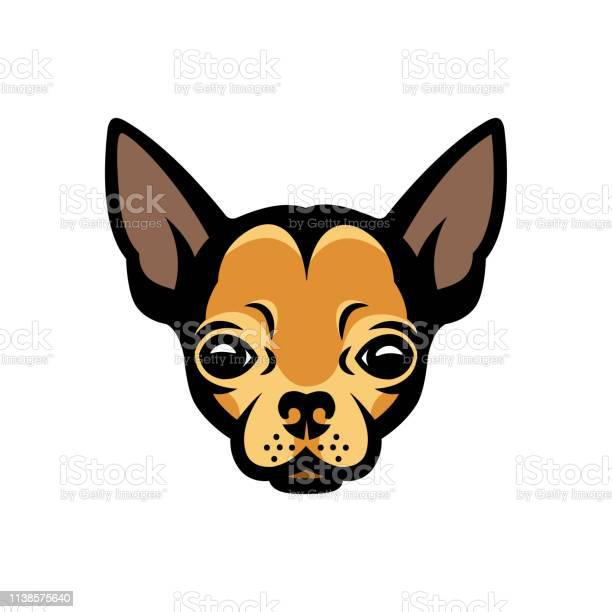

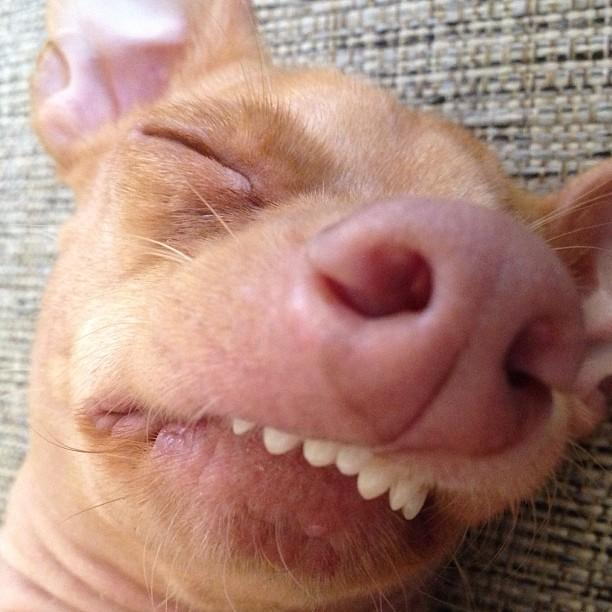

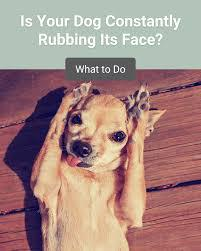

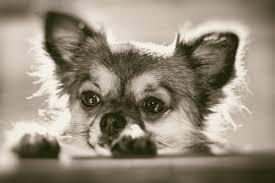

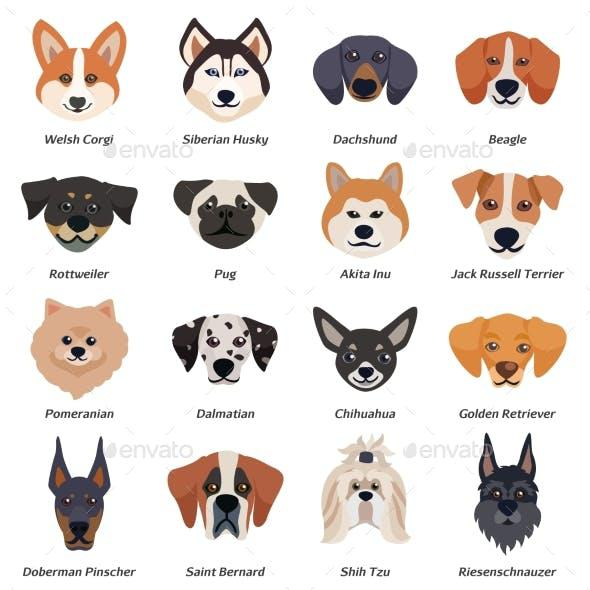

In [6]:
# load and view five images from the training images
for image in train_imgs[:5]:
    img_loaded = load_img(image)
    display(img_loaded)

Next, let's examine the shape and the values of the array representation of the image.

In [7]:
## Examine shape and values of loaded image
img_array = img_to_array(img_loaded)
image_shape = img_array.shape
print(image_shape)
img_array

(590, 590, 3)


array([[[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.]],

       ...,

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [249., 249., 249.],
        [251., 251., 251.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 255., 255.],
        ...,
        [246., 246., 246.],
        [248., 248., 248.],
        [255., 255., 255.]],

       [[255., 255., 255.],
        [255., 255., 255.],
        [255., 2

# Data Preparation: 

## Create Tensorflow Dataset

Now that we have a sense of what we have, let's set up our Tensorflow Dataset.  Remember, this is an ETL pipeline that will load batches of images from our disk into memory and use those to train the model.

This is important because we may not have enough computer memory to hold all of the images at the same time.  Instead, we just load a few, train the model on them, remove them from working memory, and then load the next batch.

Since accessing long-term computer storage is slower than accessing working memory (RAM), we will set our Dataset object to prefetch and cache the images to improve the speed at which it's able to deliver them to the model.

In [8]:
# Define some variables for later use

batch_size = 32
img_height = 128
img_width = 128

input_shape = (img_height, img_width)
input_shape

(128, 128)

In [9]:
# Create a Dataset object to stream images from the file folders.

# Training Dataset
ds_train = tf.keras.utils.image_dataset_from_directory(
    folder + '/train',
    shuffle=True,
    label_mode='categorical',
    seed=42,
    image_size=input_shape,
    batch_size=batch_size)

# Validation and testing sets
ds_val, ds_test = tf.keras.utils.image_dataset_from_directory(
    folder + '/test',
    validation_split = .5, #split the testing data into validation and test sets
    subset='both',
    shuffle=True,
    label_mode='categorical',
    seed=42,
    image_size=input_shape,
    batch_size=batch_size)
    

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
Using 592 files for training.
Using 592 files for validation.


## Create a dictionary of class names

The Dataset object will one-hot encode the classes, so it will be challenging to determine which class is actually being predicted by the model.

We can create a dictionary of class names to help us look up the string representation of the one-hot encoded class.

We have to do this before we optimize the dataset in the next step

In [10]:
# Get the class names and the number of classes
class_names = ds_train.class_names
num_classes = len(class_names)

# Create a dictionary we can use to lookup the class names.

class_dict = dict(zip(range(num_classes), class_names))
class_dict

{0: 'chihuahua', 1: 'muffin'}

### Retrieve an element to make sure the dataset object is working correctly.

We will extract one batch of images and labels and display just the first one.  We will use our `class_dict` to lookup the string name of the class label, since it is returned as a one-hot encoded array.

muffin


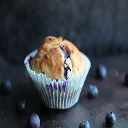

(128, 128, 3)


In [11]:
# Get one batch of images from the training set
example_imgs, example_labels= ds_train.take(1).get_single_element()
img = example_imgs[0]
label = example_labels[0]
input_shape = img.shape

## Lookup the string name of the label and display both the label and the image
label = class_dict[np.argmax(label)]
print(label)
display(array_to_img(img))
print(input_shape)

## Optimize Datasets for performance

Next we will optimize our Datasets for performance.  They will load a new batch of images into memory while the model is training on the previous batch.  They will also cache images in a way that they can be more quickly accessed.

We will use AUTOTUNE to find the optimal number of batches to prefetch and set a buffer size as large as our dataset.

We will also shuffle the data.  We need to set an appropriate buffer size for the shuffling because Tensorflow needs to load in all the data to be shuffled.  If the total number of training images is larger than our working memory (RAM), then we cannot buffer them all.  However, if they CAN all be loaded into memory, then we want to do that so we get the most uniform shuffling possible.

Buffer size is a value that is really specific to the machine you are using.  If you get an OOM (out of memory) error, then try reducing your buffer size.

In this case our images are small and they will all fit in our memory (hopefully!) so we will set the buffer size to the full size of the Dataset.

In [12]:
# Set the datasets to cache and prefetch the data.  We will also have the training batches data shuffle each time they are used.

# find the optimal size for caches based on available memory
AUTOTUNE = tf.data.AUTOTUNE

# Set training data to cache, prefect, and shuffle
ds_train = ds_train.cache().shuffle(buffer_size=len(ds_train),
                                    seed=42).prefetch(buffer_size=AUTOTUNE)

# Set validation and testing data to cache and prefetch.  There's no reason to shuffle them.
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

# Load Default Model from Lecture 1


Now let's build and fit the model!  Notice how few weights there are to train in the convolutional layer.

In [13]:
## Load previous model
path = 'Models/default_cnn'
default_model = tf.keras.models.load_model(path)
default_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 56448)             0         
                                                                 
 dense (Dense)               (None, 2)                 112898    
                                                                 
Total params: 113,794
Trainable params: 113,794
Non-trainable params: 0
________________________________________________

## Evaluate the Model


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

   chihuahua       0.93      0.99      0.96      2559
      muffin       0.99      0.92      0.95      2174

    accuracy                           0.95      4733
   macro avg       0.96      0.95      0.95      4733
weighted avg       0.96      0.95      0.95      4733



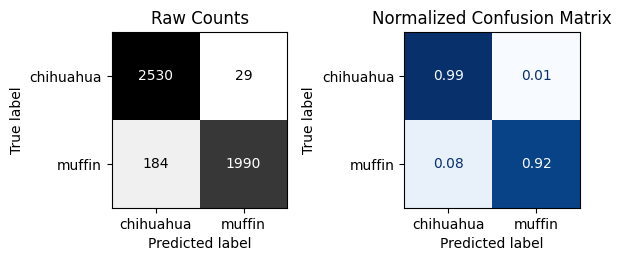

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

   chihuahua       0.82      0.87      0.84       304
      muffin       0.85      0.80      0.82       288

    accuracy                           0.83       592
   macro avg       0.83      0.83      0.83       592
weighted avg       0.83      0.83      0.83       592



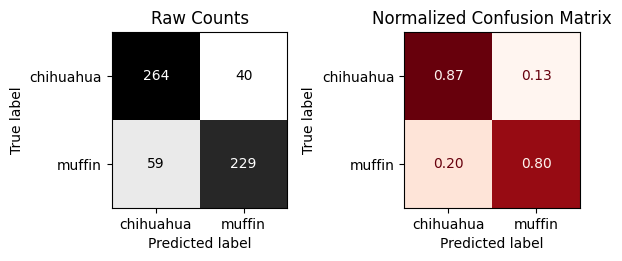

In [14]:
evaluate_classification_network(default_model, X_train=ds_train, X_test=ds_test, history=None,
                                           figsize=(6,4), class_labels=class_names)

Our model is pretty good!  It is making some mistakes and seems to be better at identifying chihuahuas than muffins.

We did notice that our model was beginning to overfit, so some regularization might help that.  

The model also learned relatively slowly.  We could consider increasing the complexity of the model as well.  We could add more convolutional and pooling layers, and/or we could add more dense layers at the bottom.

# Part 2: Transfer Learning and Lime with CNNs

## Transfer Learning
In this section we will select a pretrained model and then fine-tune it on our data.  We will see if we can get better performance than our model above.

### [Available Models in Keras](https://keras.io/api/applications/)



| Model             | Size (MB) | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth | Time (ms) per inference step (CPU) | Time (ms) per inference step (GPU) |
|-------------------|-----------|----------------|----------------|------------|-------|------------------------------------|------------------------------------|
| Xception          | 88        | 79.0%          | 94.5%          | 22.9M      | 81    | 109.4                              | 8.1                                |
| VGG16             | 528       | 71.3%          | 90.1%          | 138.4M     | 16    | 69.5                               | 4.2                                |
| VGG19             | 549       | 71.3%          | 90.0%          | 143.7M     | 19    | 84.8                               | 4.4                                |
| ResNet50          | 98        | 74.9%          | 92.1%          | 25.6M      | 107   | 58.2                               | 4.6                                |
| ResNet50V2        | 98        | 76.0%          | 93.0%          | 25.6M      | 103   | 45.6                               | 4.4                                |
| ResNet101         | 171       | 76.4%          | 92.8%          | 44.7M      | 209   | 89.6                               | 5.2                                |
| ResNet101V2       | 171       | 77.2%          | 93.8%          | 44.7M      | 205   | 72.7                               | 5.4                                |
| ResNet152         | 232       | 76.6%          | 93.1%          | 60.4M      | 311   | 127.4                              | 6.5                                |
| ResNet152V2       | 232       | 78.0%          | 94.2%          | 60.4M      | 307   | 107.5                              | 6.6                                |
| InceptionV3       | 92        | 77.9%          | 93.7%          | 23.9M      | 189   | 42.2                               | 6.9                                |
| InceptionResNetV2 | 215       | 80.3%          | 95.3%          | 55.9M      | 449   | 130.2                              | 10.0                               |
| MobileNet         | 16        | 70.4%          | 89.5%          | 4.3M       | 55    | 22.6                               | 3.4                                |
| MobileNetV2       | 14        | 71.3%          | 90.1%          | 3.5M       | 105   | 25.9                               | 3.8                                |
| DenseNet121       | 33        | 75.0%          | 92.3%          | 8.1M       | 242   | 77.1                               | 5.4                                |
| DenseNet169       | 57        | 76.2%          | 93.2%          | 14.3M      | 338   | 96.4                               | 6.3                                |
| DenseNet201       | 80        | 77.3%          | 93.6%          | 20.2M      | 402   | 127.2                              | 6.7                                |
| NASNetMobile      | 23        | 74.4%          | 91.9%          | 5.3M       | 389   | 27.0                               | 6.7                                |
| NASNetLarge       | 343       | 82.5%          | 96.0%          | 88.9M      | 533   | 344.5                              | 20.0                               |
| EfficientNetB0    | 29        | 77.1%          | 93.3%          | 5.3M       | 132   | 46.0                               | 4.9                                |
| EfficientNetB1    | 31        | 79.1%          | 94.4%          | 7.9M       | 186   | 60.2                               | 5.6                                |
| EfficientNetB2    | 36        | 80.1%          | 94.9%          | 9.2M       | 186   | 80.8                               | 6.5                                |
| EfficientNetB3    | 48        | 81.6%          | 95.7%          | 12.3M      | 210   | 140.0                              | 8.8                                |
| EfficientNetB4    | 75        | 82.9%          | 96.4%          | 19.5M      | 258   | 308.3                              | 15.1                               |
| EfficientNetB5    | 118       | 83.6%          | 96.7%          | 30.6M      | 312   | 579.2                              | 25.3                               |
| EfficientNetB6    | 166       | 84.0%          | 96.8%          | 43.3M      | 360   | 958.1                              | 40.4                               |
| EfficientNetB7    | 256       | 84.3%          | 97.0%          | 66.7M      | 438   | 1578.9                             | 61.6                               |
| EfficientNetV2B0  | 29        | 78.7%          | 94.3%          | 7.2M       | -     | -                                  | -                                  |
| EfficientNetV2B1  | 34        | 79.8%          | 95.0%          | 8.2M       | -     | -                                  | -                                  |
| EfficientNetV2B2  | 42        | 80.5%          | 95.1%          | 10.2M      | -     | -                                  | -                                  |
| EfficientNetV2B3  | 59        | 82.0%          | 95.8%          | 14.5M      | -     | -                                  | -                                  |
| EfficientNetV2S   | 88        | 83.9%          | 96.7%          | 21.6M      | -     | -                                  | -                                  |
| EfficientNetV2M   | 220       | 85.3%          | 97.4%          | 54.4M      | -     | -                                  | -                                  |
| EfficientNetV2L   | 479       | 85.7%          | 97.5%          | 119.0M     | -     | -                                  | -                                  |
| ConvNeXtTiny      | 109.42    | 81.3%          | -              | 28.6M      | -     | -                                  | -                                  |
| ConvNeXtSmall     | 192.29    | 82.3%          | -              | 50.2M      | -     | -                                  | -                                  |
| ConvNeXtBase      | 338.58    | 85.3%          | -              | 88.5M      | -     | -                                  | -                                  |
| ConvNeXtLarge     | 755.07    | 86.3%          | -              | 197.7M     | -     | -                                  | -                                  |
| ConvNeXtXLarge    | 1310      | 86.7%          | -              | 350.1M     | -     | -                                  | -                                  |                               | -    |nvNeXtXLarge	1310	86.7%	-	350.1M	-	-	-

## Select a model and load it.

Remember to load it:

Without top layers (we are going to add our own)

with pretrained weights (imagenet)

And with the correct number of classes (in this case 1000)

Preprocess inputs with the .preprocess_input method.  We will do this using by wrapping the function in a `layers.Lambda` layer.  This also requires adding an Input Layer to the model as well.

We also need to remember to set the model to `model.trainable = False` so we don't overwrite the trained layers.

In [15]:
## Load the model.

pretrained = tf.keras.applications.Xception(input_shape=input_shape,
                                     include_top=False,
                                     weights='imagenet',
                                     classes=num_classes)

pretrained.trainable=False
preprocessing = tf.keras.applications.xception.preprocess_input

In [16]:
# !pip install --force-reinstall -v "pillow<=9.5.0"

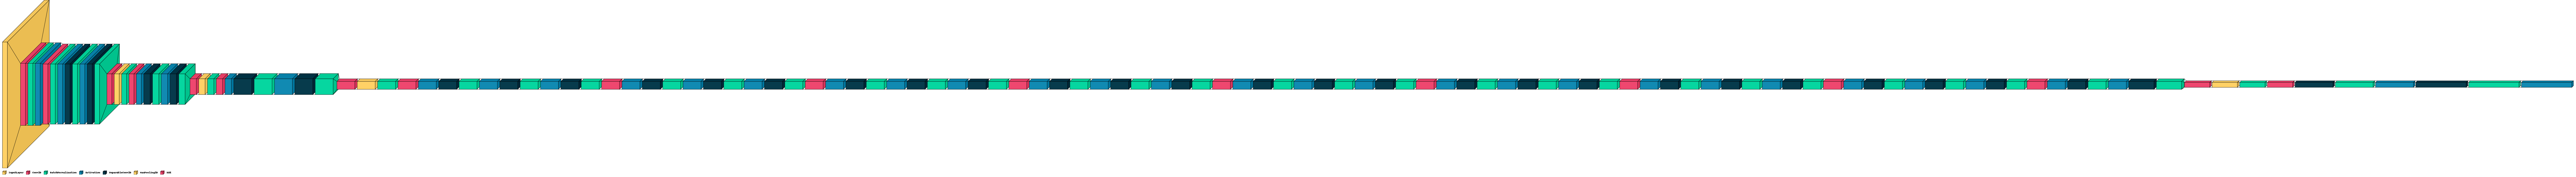

In [17]:
vk.layered_view(pretrained, legend=True)

As we build the model we will add an Input layer to convert the inputs into tensors.  Then we will add the preprocessing layer and the pretrained model.  Finally, we will add dense layers that are trainable that we can use to fine tune the model.

In [18]:
def build_transfer_model():

    ## Initialize Model
    model = models.Sequential()

    ## Add input layer
    model.add(layers.Input(shape=input_shape, name='input'))

    ## Add the preprocessing layer
    model.add(layers.Lambda(preprocessing, name='preprocessing'))

    ## Add the pretrained layers
    model.add(pretrained)

    ## Flatten the Data
    model.add(layers.Flatten())
    
    ## Add a dropout layer for regularization
    model.add(layers.Dense(32))
    model.add(layers.Dense(32))
    
    ## Add the output layer
    model.add(layers.Dense(units=num_classes, activation='softmax'))
    
    ## Complile the model and return it.
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    display(model.summary())
    return model

In [19]:
## fit the model

transfer_model = build_transfer_model()



history = transfer_model.fit(ds_train,
                              validation_data=ds_val,
                              epochs=25,
                              callbacks=[callbacks.EarlyStopping(patience=5)]
                            )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Lambda)      (None, 128, 128, 3)       0         
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 21,911,210
Trainable params: 1,049,730
Non

None

Epoch 1/25
148/148 [==============================] - 11s 53ms/step - loss: 0.2351 - accuracy: 0.9649 - val_loss: 0.0577 - val_accuracy: 0.9780
Epoch 2/25
148/148 [==============================] - 7s 47ms/step - loss: 0.0319 - accuracy: 0.9894 - val_loss: 0.0722 - val_accuracy: 0.9814
Epoch 3/25
148/148 [==============================] - 6s 42ms/step - loss: 0.0217 - accuracy: 0.9932 - val_loss: 0.0825 - val_accuracy: 0.9831
Epoch 4/25
148/148 [==============================] - 7s 44ms/step - loss: 1.2122 - accuracy: 0.9681 - val_loss: 0.3213 - val_accuracy: 0.9713
Epoch 5/25
148/148 [==============================] - 7s 47ms/step - loss: 0.0539 - accuracy: 0.9899 - val_loss: 0.1844 - val_accuracy: 0.9764
Epoch 6/25
148/148 [==============================] - 7s 47ms/step - loss: 0.0084 - accuracy: 0.9966 - val_loss: 0.1943 - val_accuracy: 0.9797



- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

   chihuahua       1.00      1.00      1.00      2559
      muffin       1.00      1.00      1.00      2174

    accuracy                           1.00      4733
   macro avg       1.00      1.00      1.00      4733
weighted avg       1.00      1.00      1.00      4733



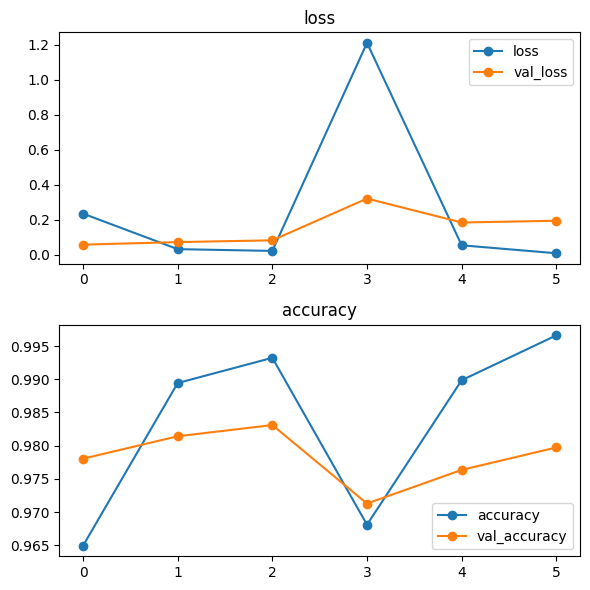

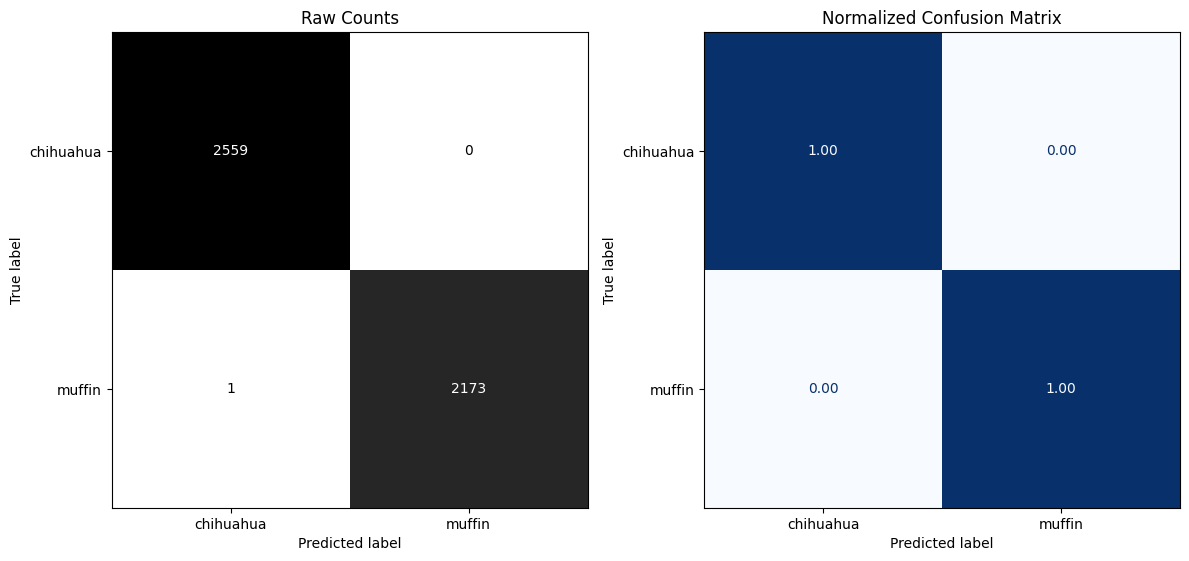

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

   chihuahua       0.97      0.99      0.98       304
      muffin       0.99      0.97      0.98       288

    accuracy                           0.98       592
   macro avg       0.98      0.98      0.98       592
weighted avg       0.98      0.98      0.98       592



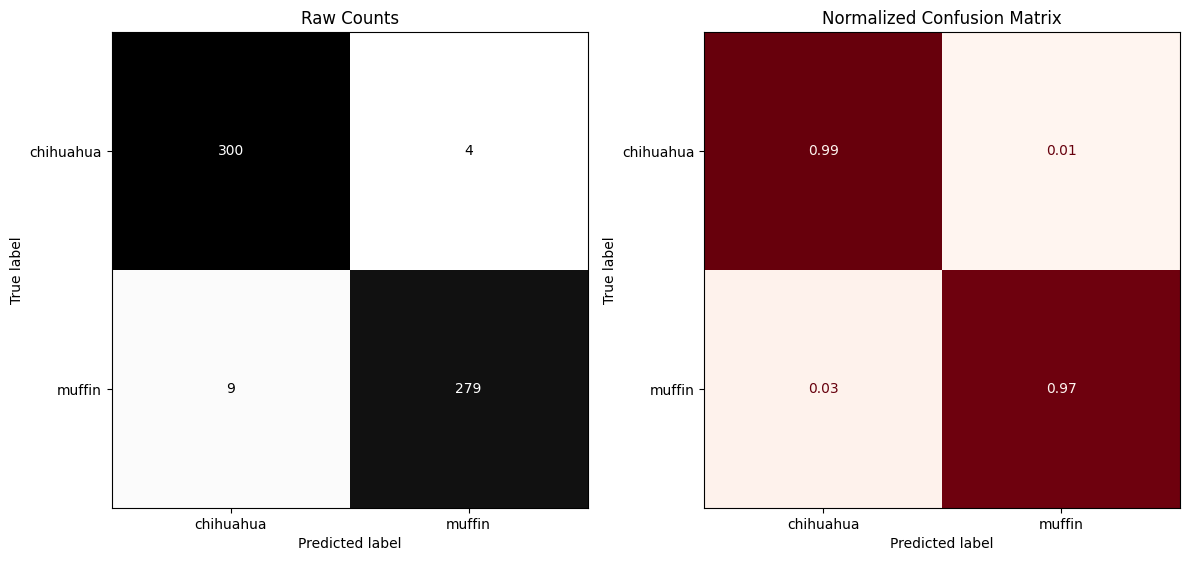

In [20]:
# Evaluate the model
evaluate_classification_network(transfer_model, X_train=ds_train, X_test=ds_test, history=history,
                                           figsize=(12,8), class_labels=class_names)

Often times the transfer model will perform much better than smaller models we train ourselves, but not always.  In this case we got a big improvement!

In [21]:
## Save the model

transfer_model.save('Models/transfer_model')

INFO:tensorflow:Assets written to: Models/transfer_model\assets


INFO:tensorflow:Assets written to: Models/transfer_model\assets


In [22]:
loaded_model = tf.keras.models.load_model('Models/transfer_model')


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

   chihuahua       1.00      1.00      1.00      2559
      muffin       1.00      1.00      1.00      2174

    accuracy                           1.00      4733
   macro avg       1.00      1.00      1.00      4733
weighted avg       1.00      1.00      1.00      4733



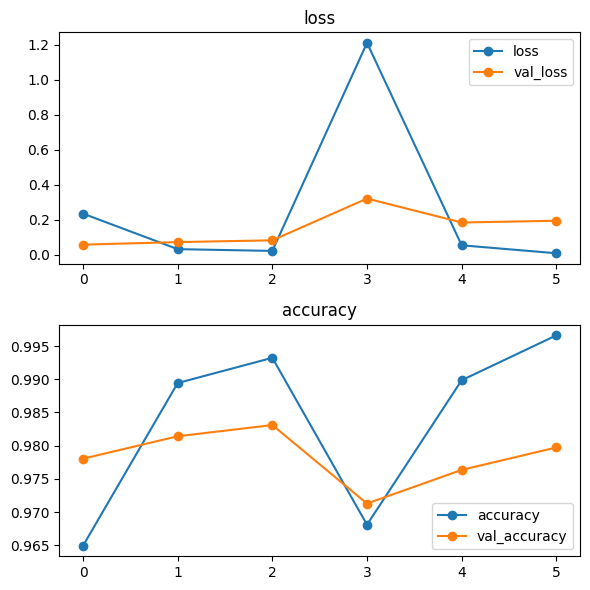

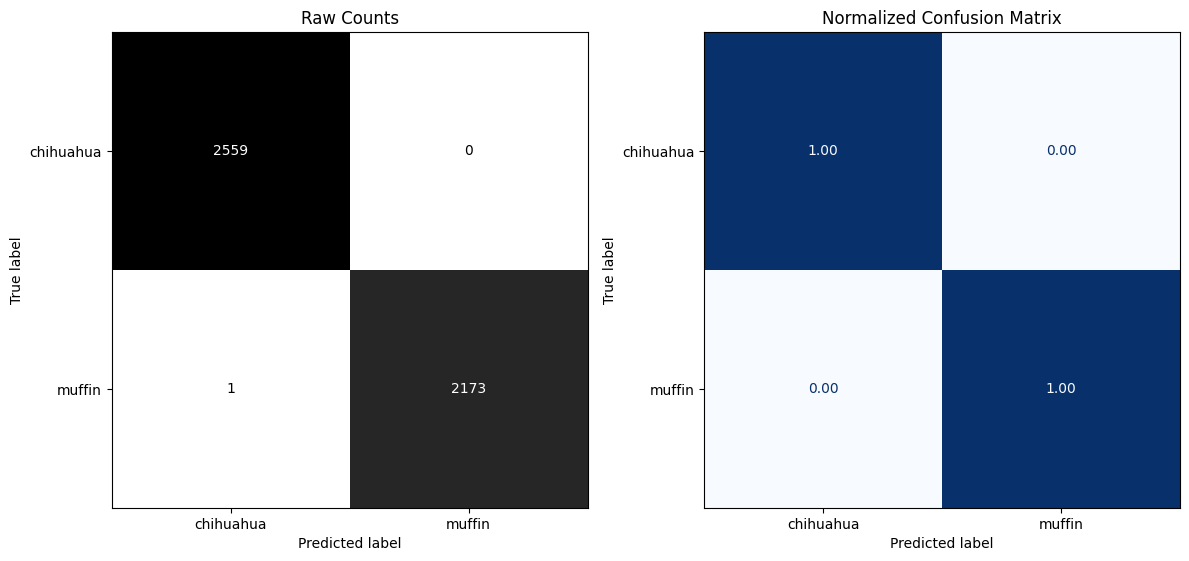

----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

   chihuahua       0.97      0.99      0.98       304
      muffin       0.99      0.97      0.98       288

    accuracy                           0.98       592
   macro avg       0.98      0.98      0.98       592
weighted avg       0.98      0.98      0.98       592



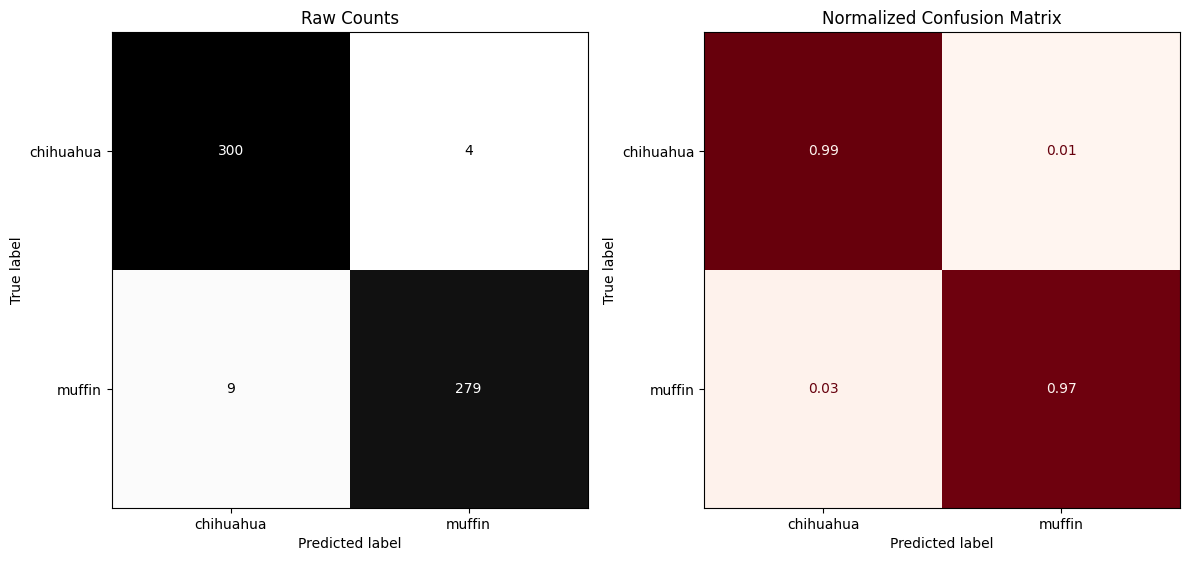

In [23]:
evaluate_classification_network(loaded_model, X_train=ds_train, X_test=ds_test, history=history,
                                           figsize=(12,8), class_labels=class_names)

## Explaining CNNs with Lime

In this section we will use the LimeImageExplainer to create a visual representation of how the model is classifying images.

We will:

1. Extract model predictions from the model.
2. Create a LimeImageExplainer object
3. Create an explanation object
4. Generate an image with a mask that shows which 

First, we will make a model prediction and extract the predicted and true labels

In [24]:
# Previous Helper Function    
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y has is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y has 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)
def get_true_pred_labels_images(model,ds, include_images=True, convert_y_for_sklearn=False):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: 
    https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    all_images = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
        if include_images==True:
            all_images.extend(images)
            
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    ## Convert to classes (or not)
    if convert_y_for_sklearn==True:
        # Use our previous helper function to make preds into classes
        y_true = convert_y_to_sklearn_classes(y_true)
        y_pred = convert_y_to_sklearn_classes(y_pred_probs)
        
    else: 
        y_pred = y_pred_probs
    
    ## IF the images should be included or not
    if include_images==False:
        return y_true, y_pred
    else:
        # Convert images to array and return everything
        all_images = np.array(all_images)
        return y_true, y_pred, all_images



Next, we will instantiate the the explainer

In [25]:
y_test, y_hat, X_test = get_true_pred_labels_images(transfer_model, ds_test, convert_y_for_sklearn=True)

Let's examine an image and its prediction

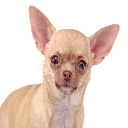

True label chihuahua
predicted label chihuahua


In [33]:
i = 12
display(array_to_img(X_test[i]))
true_label = class_dict[y_test[i]]
predicted_label = class_dict[y_hat[i]]
print('True label', true_label)
print('predicted label', predicted_label)

In [36]:
prediction = transfer_model.predict(X_test[i].reshape([1, *X_test[i].shape]))
print('raw prediction: ', prediction)
print('prediction lookup: ', class_dict[np.argmax(prediction)])

1/1 [==============================] - 0s 196ms/step
raw prediction:  [[1. 0.]]
prediction lookup:  chihuahua


Now we will create a Lime explanation for this model prediction

In [28]:
# !pip install scikit-image
# !pip install lime

In [29]:
from skimage.segmentation import mark_boundaries
from lime import lime_image

In [30]:
explainer = lime_image.LimeImageExplainer(verbose=False)
explainer

In [31]:
explanation = explainer.explain_instance(X_test[i],
                                         transfer_model.predict,
                                         top_labels=1,
                                         num_samples=1000,
                                         hide_color=0,
                                         random_seed=42,
                                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


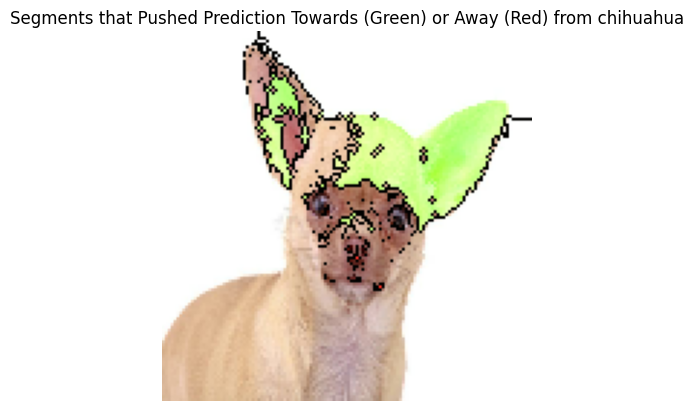

In [34]:
# Show positive and negative on same image
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            negative_only=False, 
                                            positive_only=False,
                                            num_features=5, 
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp, mask, mode='inner').astype(int))
plt.axis('off')
plt.title(f'Segments that Pushed Prediction Towards (Green) or Away (Red) from {true_label}');